In [5]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gsw
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 4})

In [6]:
# We shall use the most recent model years, which at the moment is 1026 to 1030
rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
datadir = 'ocean_annual_z_1x1deg/ts/annual/5yr/'
filename_age = 'ocean_annual_z_1x1deg.1026-1030.agessc.nc'
filename_temp = 'ocean_annual_z_1x1deg.1026-1030.thetao.nc'
filename_vol = 'ocean_annual_z_1x1deg.1026-1030.volcello.nc'
filename_so = 'ocean_annual_z_1x1deg.1026-1030.so.nc'
datadir05 = 'ocean_annual_z/ts/annual/5yr/'
filename_temp05 = 'ocean_annual_z.1026-1030.thetao.nc'

In [7]:
age = xr.open_dataset(rootdir + datadir + filename_age) # Ideal Age
temp = xr.open_dataset(rootdir + datadir + filename_temp) # Temperature
vol = xr.open_dataset(rootdir + datadir + filename_vol) #Volume
so = xr.open_dataset(rootdir + datadir + filename_so) #Salinity
temp05 = xr.open_dataset(rootdir + datadir05 +filename_temp05) # Temp but in 0.5 degrees

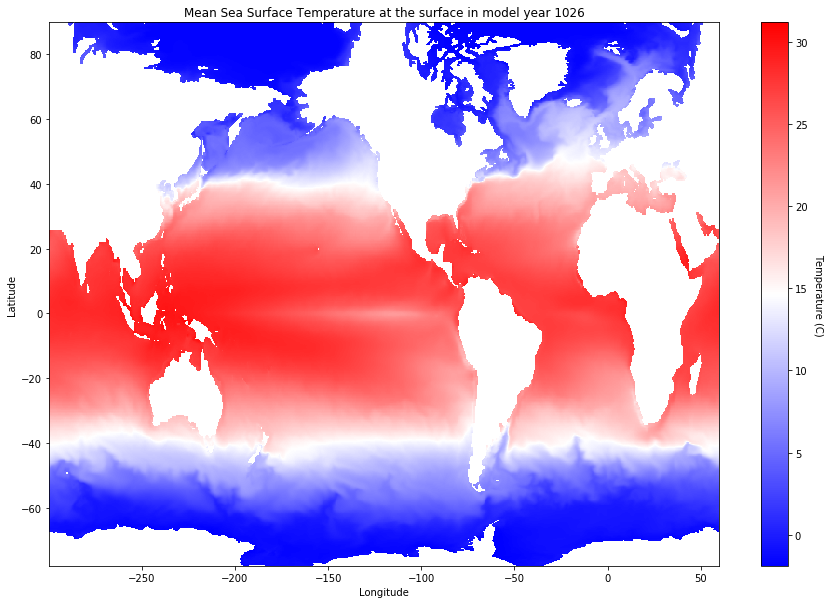

In [8]:
# plot the temperature one first to show ESM4! 
plt.figure(figsize = (15,10)) #Changes the size of the figure, larger map makes it easier to see data
im = plt.pcolormesh(temp05.xh, temp05.yh, temp05.thetao.isel(time = 0, z_l =0), cmap = cm.bwr) 
cbar = plt.colorbar(im)
plt.title('Mean Sea Surface Temperature at the surface in model year 1026')
cbar.set_label('Temperature (C)', rotation =270, labelpad=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [9]:
potden = gsw.density.sigma2(so.so, temp.thetao)
lat = so.lat 
lon = so.lon
time = so.time
z_l = so.z_l

In [10]:
pot_den = xr.DataArray(potden, coords = [time, z_l, lat, lon ], dims = ['time', 'z_l', 'lat', 'lon'])
pot_den.name = 'Potential_Density'
ds = xr.merge([temp, age, vol, so])
df = xr.merge([ds, pot_den])
print(df)

<xarray.Dataset>
Dimensions:            (bnds: 2, lat: 180, lon: 360, time: 5, z_i: 36, z_l: 35)
Coordinates:
  * lat                (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time               (time) object 1026-07-02 12:00:00 ... 1030-07-02 12:00:00
  * z_i                (z_i) float64 0.0 5.0 15.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l                (z_l) float64 2.5 10.0 20.0 ... 5.5e+03 6e+03 6.5e+03
Dimensions without coordinates: bnds
Data variables:
    average_DT         (time) timedelta64[ns] 365 days 365 days ... 365 days
    average_T1         (time) object 1025-04-20 00:00:00 ... 1029-04-19 00:00:00
    average_T2         (time) object 1026-04-20 00:00:00 ... 1030-04-19 00:00:00
    lat_bnds           (lat, bnds) float64 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    lon_bnds           (lon, bnds) float64 0.0 1.0 1.0 2.0 ... 359.0 359.0 360.0
    thetao             (time, z_l, la

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/num

In [11]:
def weightedstd(ds,variable,weights):
    # variable and weights are strings
    M = ds[variable].size
    variable_times_weights = ds[variable]*ds[weights]
    weightedmean = variable_times_weights.sum()/ds[weights].sum()
    numerator = ds[weights]*(ds[variable]-weightedmean)**2
    numerator = numerator.sum()
    denominator = ((M-1)/M)*ds[weights].sum()
    weightedstd = numerator/denominator
    return weightedstd**(0.5)
def weightedmean(ds,variable,weights):
    # variable and weights are strings
    variable_times_weights = ds[variable]*ds[weights]
    weightedmean = variable_times_weights.sum()/ds[weights].sum()
    return weightedmean

In [12]:
def calculate(dataset, sort, bins, bin_label, t, var, w, bol):
    # dataset => dataset you use, sort => what are you grouping with, t = what time, var => variable, w= weight, 
    # bol = a boolean, true = want weighted mean, false want weighted std)
    newdataset = dataset.isel(time=t).groupby_bins(sort, bins, labels=bin_label)
    mean = newdataset.apply(weightedmean, variable = var, weights = w)
    wstd = newdataset.apply(weightedstd, variable = var, weights= w)
    if (bol == True):
        return mean
    else: 
        return wstd

In [13]:
def binplots(x, y, error, labely, labelx, year):
    plt.figure(figsize = (15,10))
    plt.errorbar(x, y, xerr = error, marker = 'o', linestyle = '--', markeredgecolor = 'r')
    plt.title('Average Age with respect to depth with volume weighted average for year ' + str(year))
    plt.gca().invert_yaxis() # Flips y axis, since depth of 0 is the ocean surface, but for comparison purposes we will not do that
    plt.ylabel(labely)
    plt.xlabel(labelx)
    plt.show()

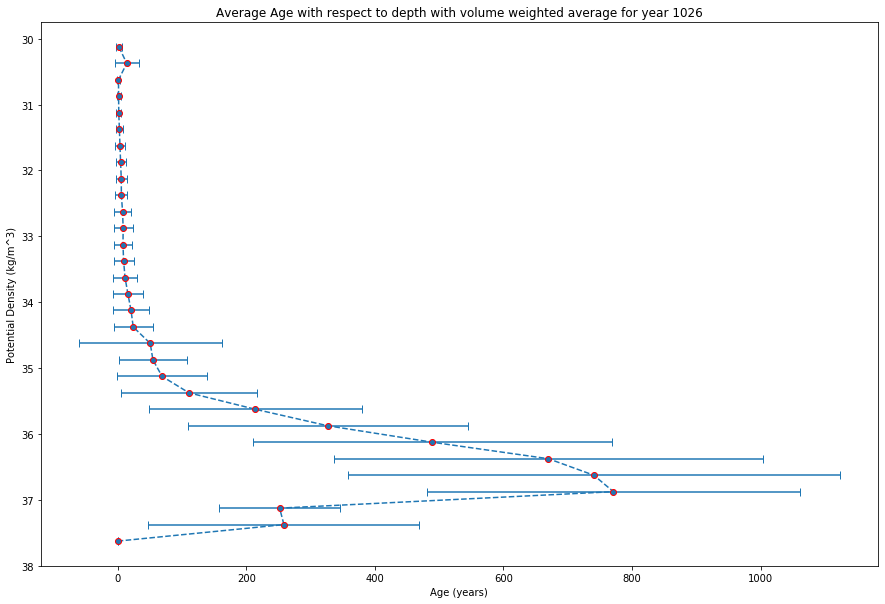

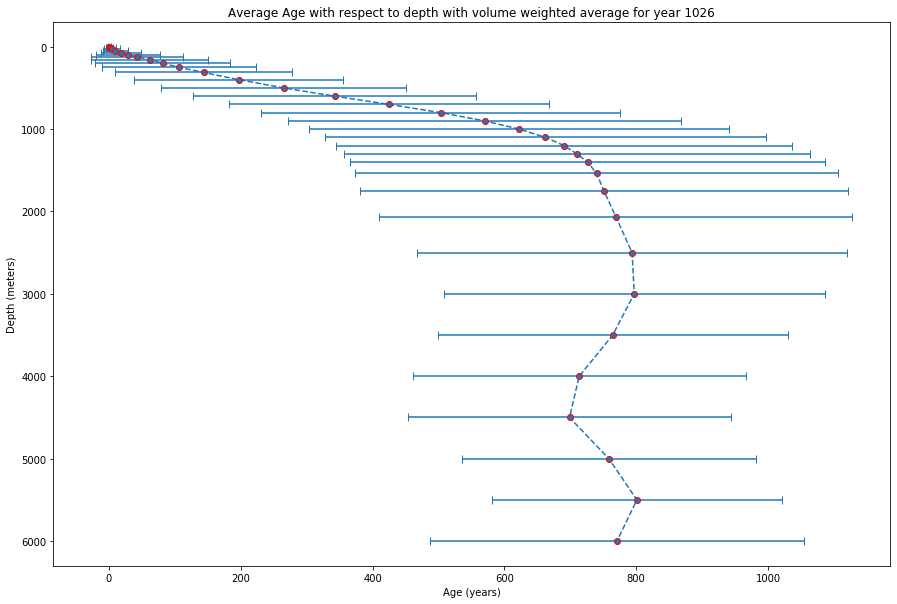

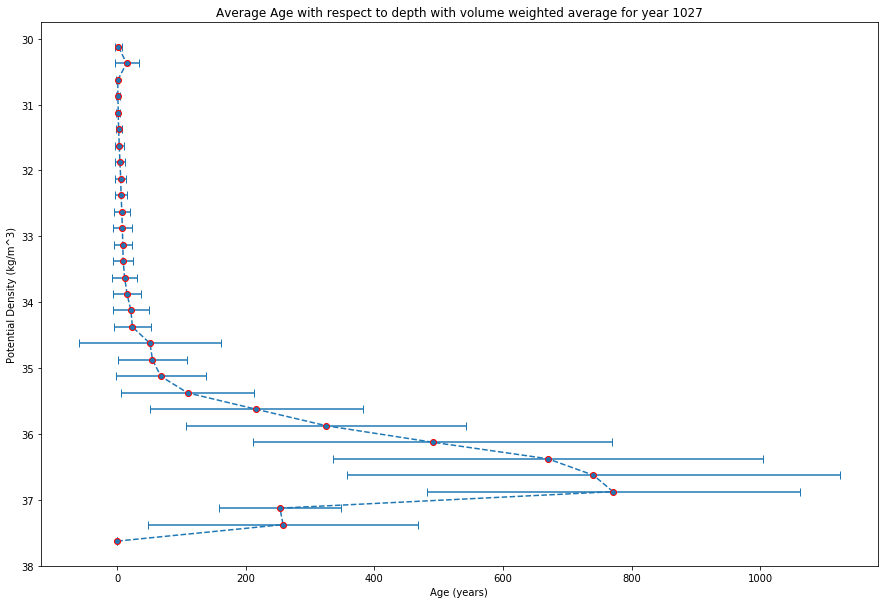

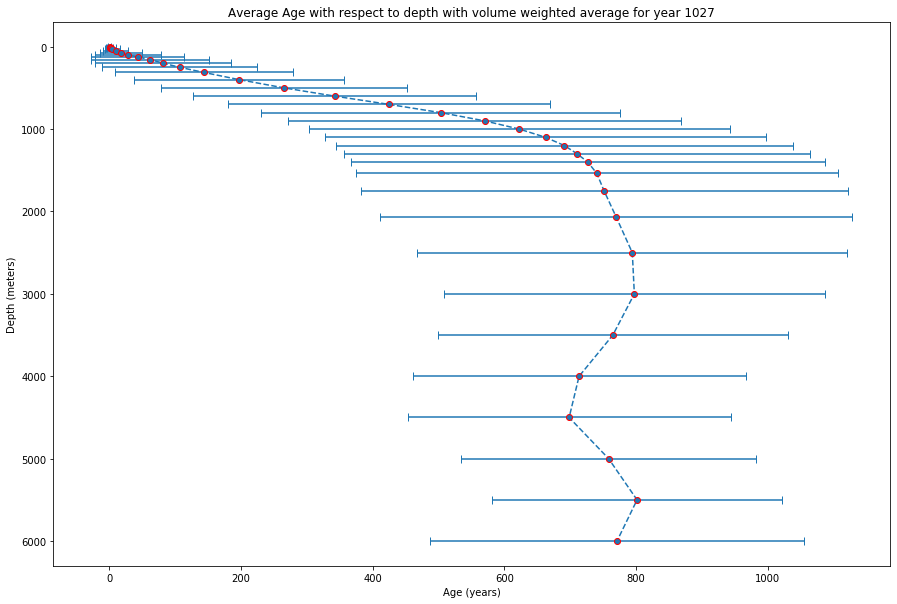

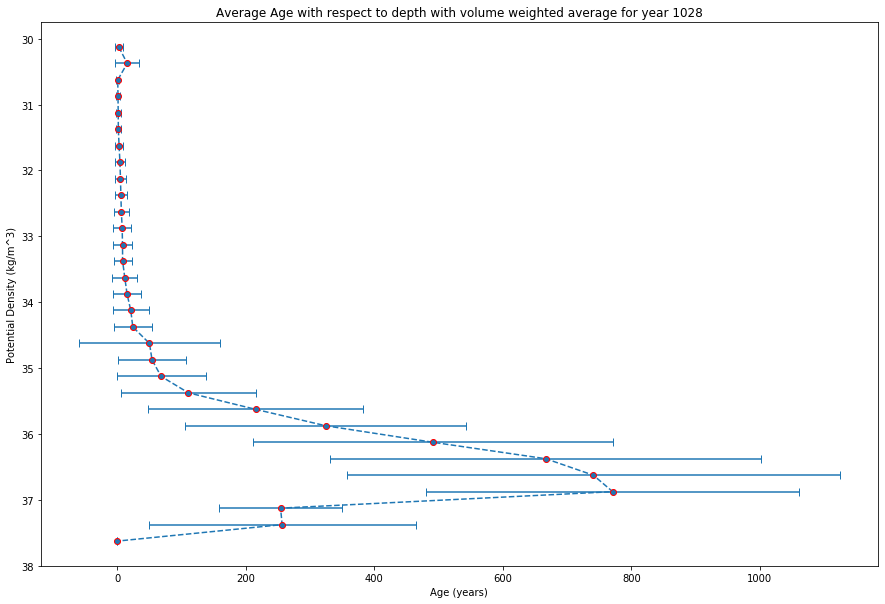

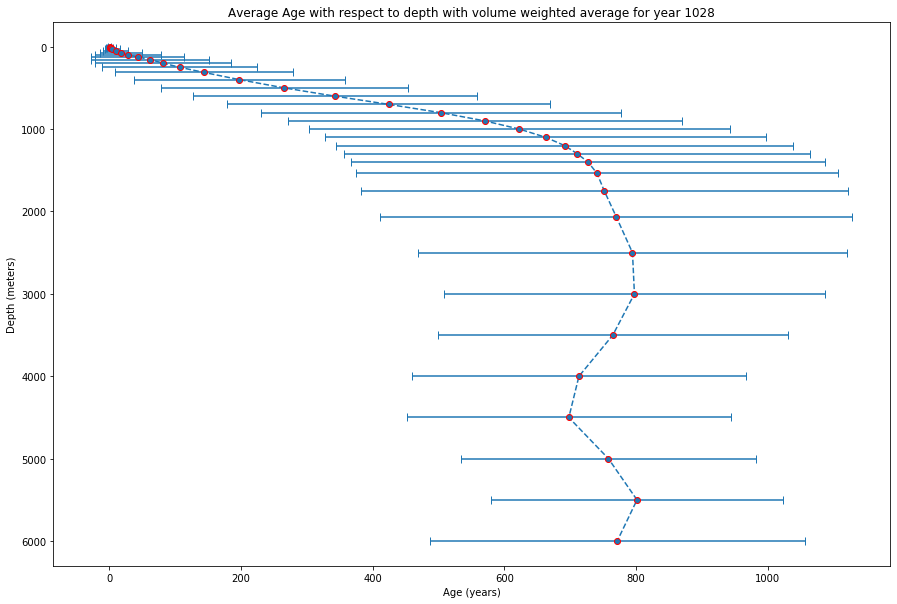

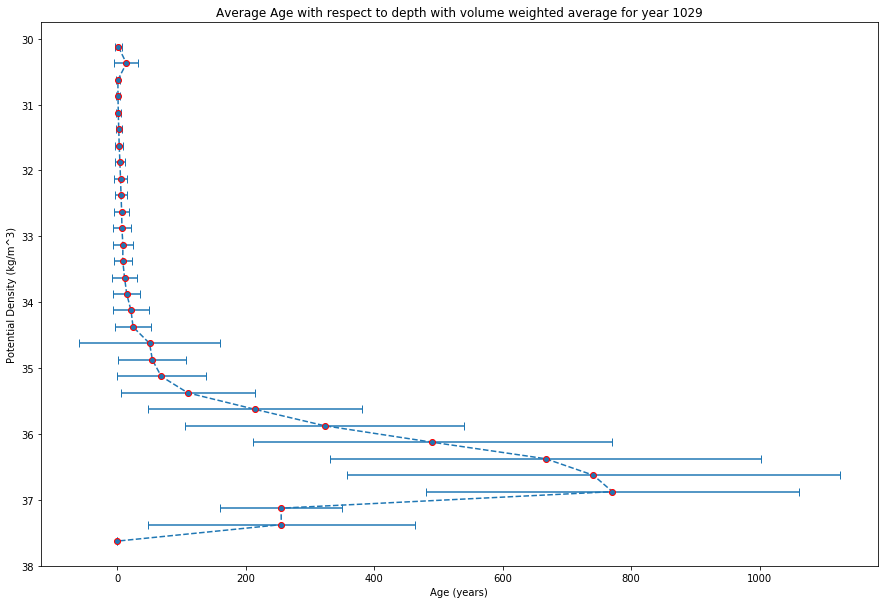

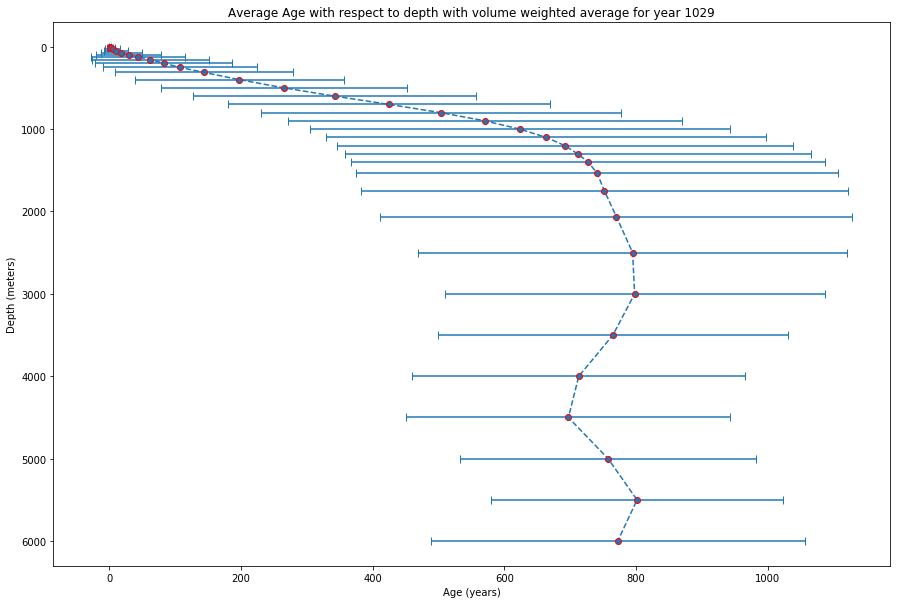

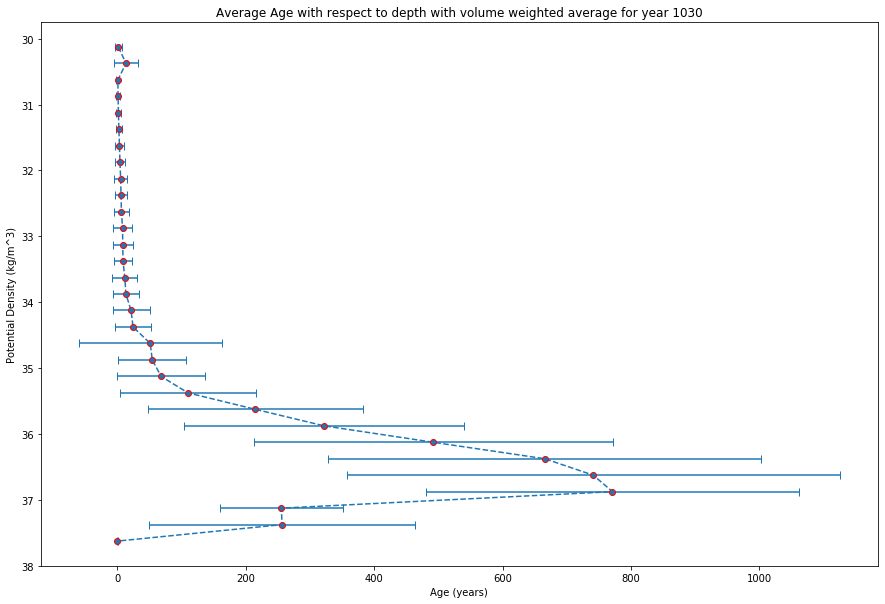

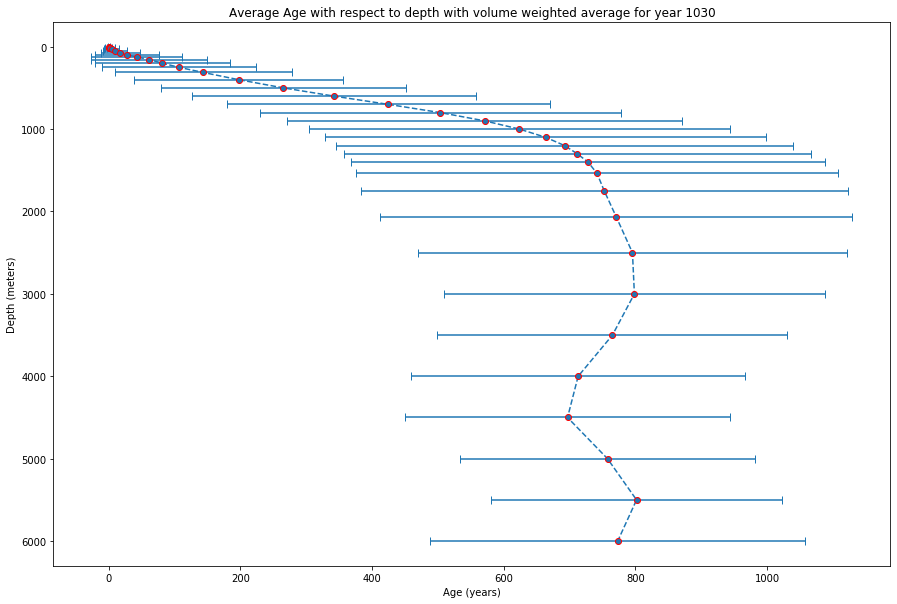

In [14]:
potden_bins = np.arange(30, 38, 0.25)
potden_bins_labels = np.arange(30.125, 37.875, .25)
z_small = z_l[:34]
for i in range(0, 5):
    den_mean = calculate(df, 'Potential_Density', potden_bins, potden_bins_labels, i, 'agessc', 'volcello', True)
    den_wstd = calculate(df, 'Potential_Density', potden_bins, potden_bins_labels, i, 'agessc', 'volcello', False)
    dep_mean = calculate(df, 'z_l', z_l, z_small, i, 'agessc', 'volcello', True)
    dep_wstd = calculate(df, 'z_l', z_l, z_small, i, 'agessc', 'volcello', False)
    binplots(den_mean, potden_bins_labels, den_wstd, 'Potential Density (kg/m^3)', 'Age (years)', 1026+i)
    binplots(dep_mean, z_small, dep_wstd, 'Depth (meters)', 'Age (years)', 1026+i)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


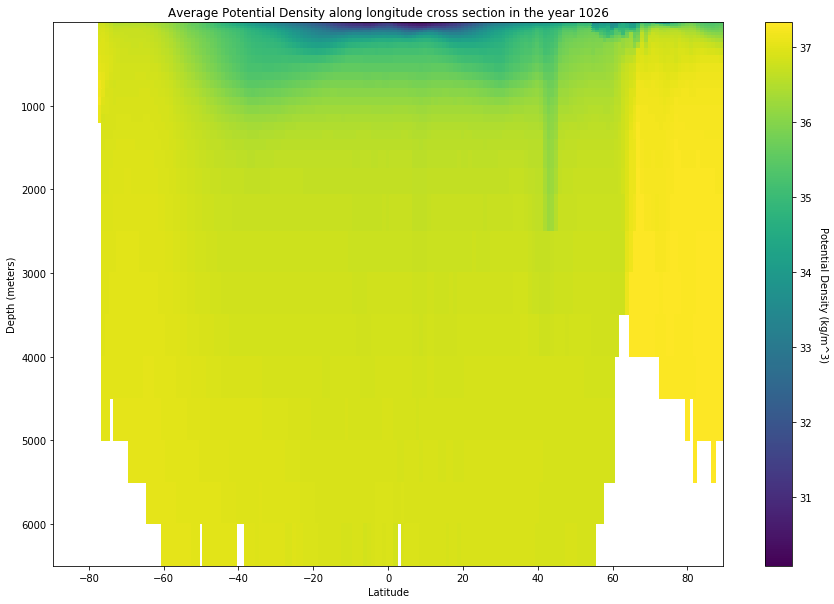

In [15]:
age_average = age.agessc.mean('lon')
density_average = df.Potential_Density.mean('lon')
plt.figure(figsize = (15,10))
a = plt.pcolormesh(df.lat, df.z_l, density_average[0])
cbar = plt.colorbar(a)
cbar.set_label('Potential Density (kg/m^3)', rotation =270, labelpad=16)
plt.gca().invert_yaxis()

plt.title('Average Potential Density along longitude cross section in the year 1026')
plt.xlabel('Latitude')
plt.ylabel('Depth (meters)')
plt.show()

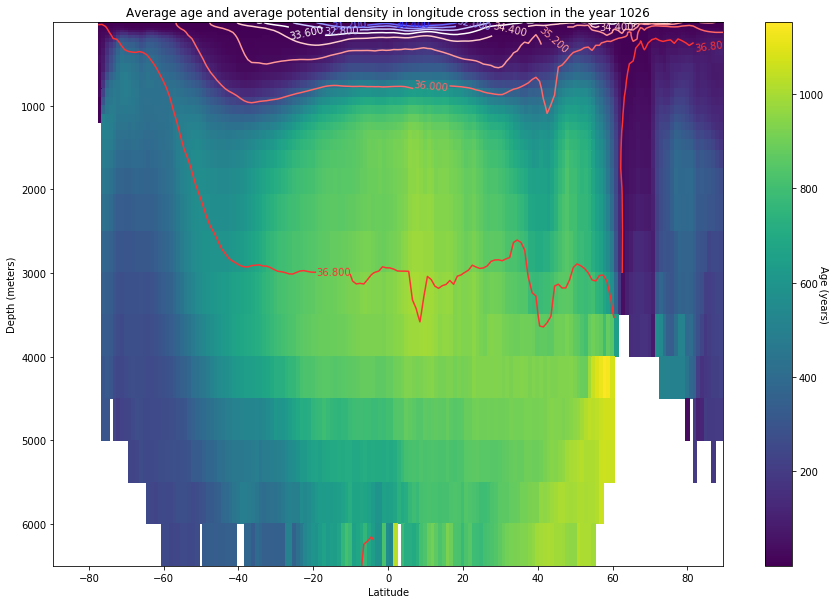

In [16]:
plt.figure(figsize = (15,10))
im = plt.pcolormesh(df.lat, df.z_l, age_average[0])
a = plt.contour(df.lat, df.z_l, density_average[0], 10, cmap = plt.cm.bwr)
plt.clabel(a, inline = 1, fontsize = 10)
cbar = plt.colorbar(im)
cbar.set_label('Age (years)', rotation = 270)
plt.gca().invert_yaxis()
plt.title('Average age and average potential density in longitude cross section in the year 1026')
plt.xlabel('Latitude')
plt.ylabel('Depth (meters)')
plt.show()

In [17]:
# here are some plots of depth with respect to density. 
plotting = np.asarray(df.Potential_Density[0])
volle = np.asarray(df.volcello[0])
deptharray = np.array(df.z_l)
def depthplots(density, volume, depth, val, val2):
    depthplot = np.full([180, 360], 0)
    volplot = np.full([180, 360], 0)
    for i in range(0, 35):
        for j in range(0, 180):
            for k in range(0, 360):
                a = density[i][j][k]
                b = volume[i][j][k]
                if (a < val2 and a > val):
                    depthplot[j][k] += depth[i]*b
                    volplot[j][k] += b
    # Let's see if this works
    refplot = depthplot/volplot
    plt.figure(figsize = (15,10))
    im = plt.pcolormesh(lon, lat, refplot)
    cbar = plt.colorbar(im)
    cbar.set_label('Depth (meters)', rotation = 270, labelpad=16)
    plt.title('Average depth of Potential Density contours between ' + str(val) + ' and ' + str(val2) + ' in year 1026')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


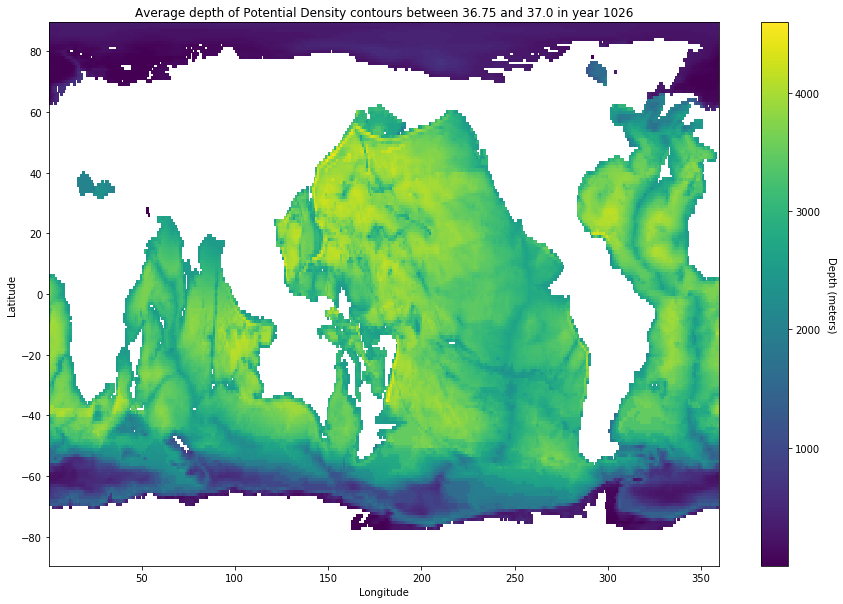

In [18]:
depthplots(plotting, volle, deptharray, 36.75, 37.0)

In [24]:
def ageplots(density, volume, age, val, val2):
    depthplot = np.full([180, 360], 0)
    volplot = np.full([180, 360], 0)
    for i in range(0, 35):
        for j in range(0, 180):
            for k in range(0, 360):
                a = density[i][j][k]
                b = volume[i][j][k]
                if (a < val2 and a >= val):
                    c = age[i][j][k]
                    depthplot[j][k] += age[i][j][k]*b
                    volplot[j][k] += b
    # Let's see if this works
    refplot = depthplot/volplot
    plt.figure(figsize = (15,10))
    im = plt.pcolormesh(refplot)
    cbar = plt.colorbar(im)
    cbar.set_label('Age (years)', rotation = 270, labelpad = 16)
    plt.title('Average age of Potential Density contours between ' + str(val) + ' and ' + str(val2) + ' in year 1026')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [25]:
newagearray = np.array(df.agessc[0])

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


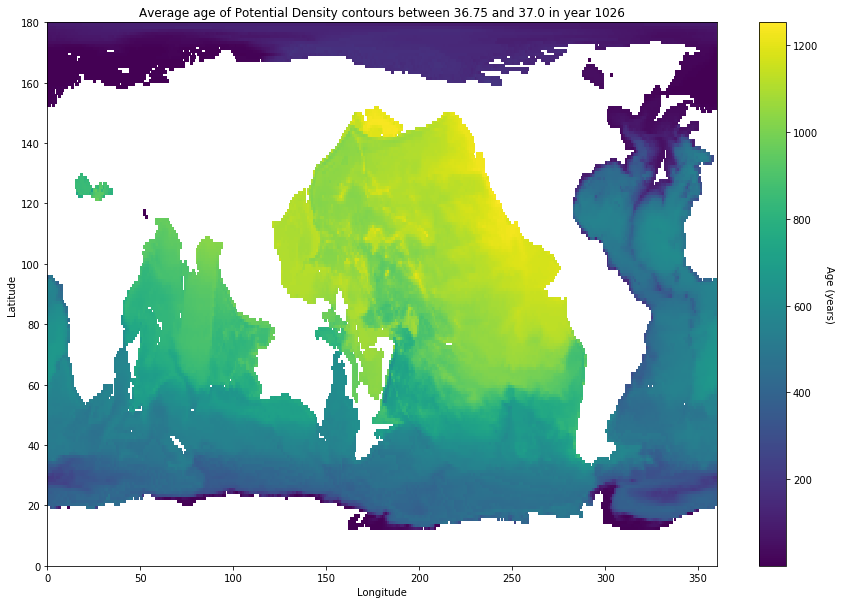

In [26]:
ageplots(plotting, volle, newagearray, 36.75, 37.0)


/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


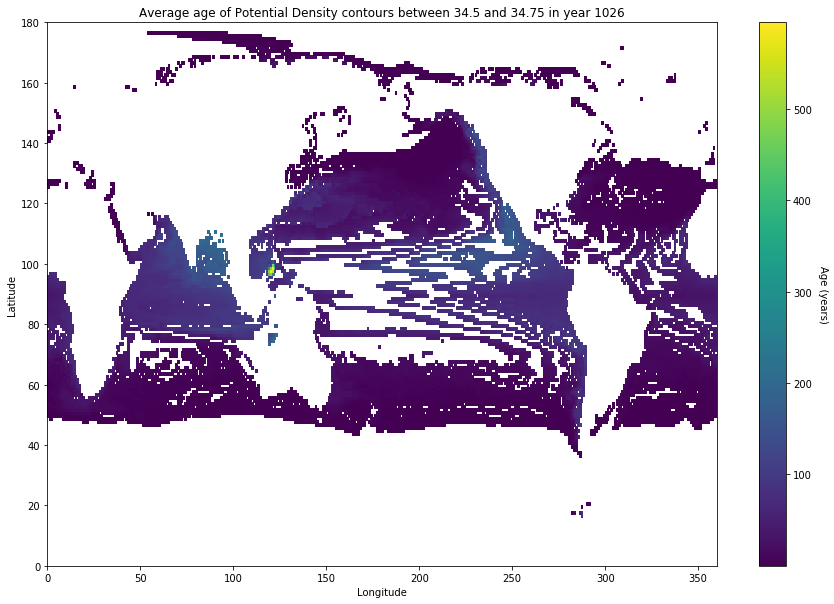

In [27]:
ageplots(plotting, volle, newagearray, 34.50, 34.75)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


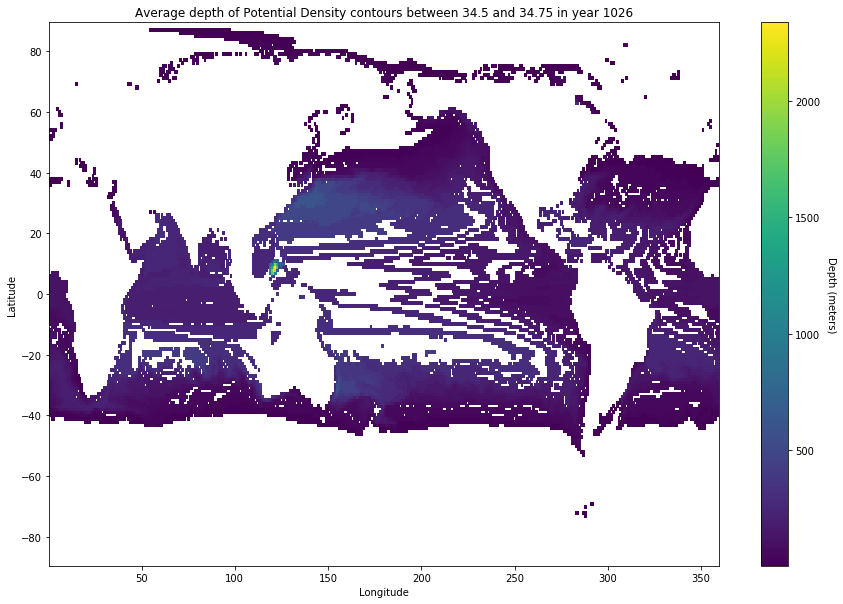

In [28]:
depthplots(plotting, volle, deptharray, 34.5, 34.75)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


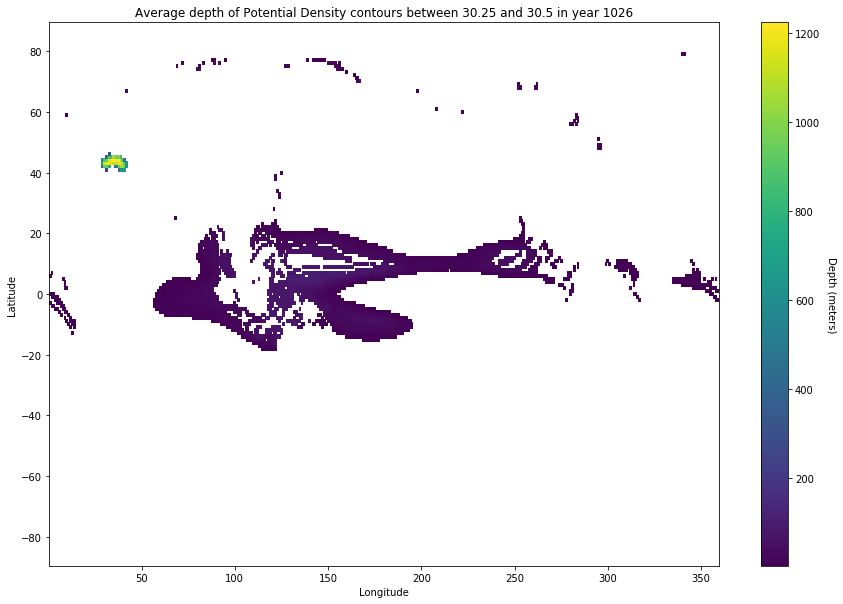

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


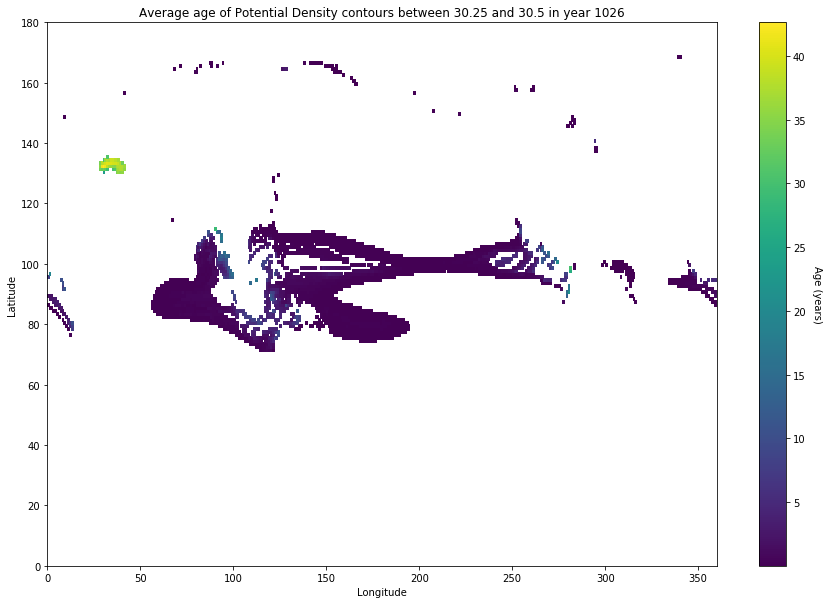

In [33]:
ageplots(plotting, volle, newagearray, 30.25, 30.5)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


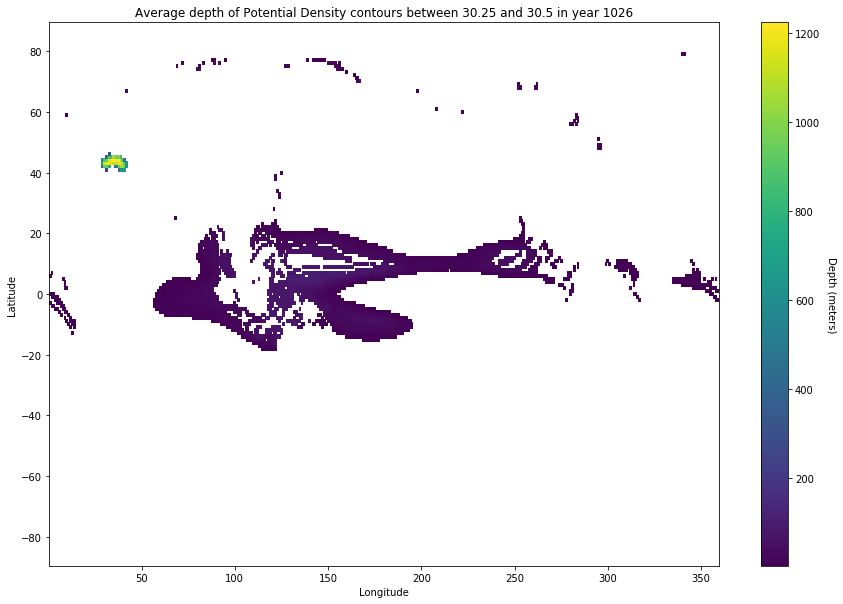

In [35]:
depthplots(plotting, volle, deptharray, 30.25, 30.5)